# Grover's search

Author : Dhiraj Madan, Advisory Research Engineer, IBM Research India

---
Done as part of the NPTEL Course - Introduction to Quantum Computing: Quantum Algorithms and Qiskit
https://onlinecourses.nptel.ac.in/noc21_cs103/preview

 We will learn to implement Grover's search algorithm in this notebook.   
 The aim of Grover's Algorithm is to find the marked index in a list of elements.  
 The space we are searching is |0000>, |0001>, |0010>, ... |1111>  
 Binary Representation - q0 is the LSB and q3 is the MSB

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()
print("Process Complete!")

Process Complete!


In [2]:
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
print("Process Complete!")

Process Complete!


We will work with 4 qubit data registers. Here we will search for an element amongs 0 to 2^4 -1 =15
We will create an ancilla qubit to store |->. This will be needed to provide a phase.

In [3]:
n=4
grover_ckt = QuantumCircuit(n+1, n)
marked = [1,0,1,1] # 1101 element is marked (lsb to msb)=>13
print("Process Complete!")

Process Complete!


Here is our oracle function. For a given n (number of data qubits), an integer marked (the index of marked element) and a circuit,
it applies the following oracle $U_{marked}|x>|y> =|x>|y \oplus f(x)>$. 

Here f(x) = 1 if  x is the marked index and 0 otherwise.


In [4]:
def apply_oracle(n,marked,ckt):
    """
    The oracle will be given as a black box, but we'll implement it from scratch in this case
    This excludes the ancilla qubit |->
    
    Here marked is a list containing the marked number in binary.
    Since qiskit takes the lsb first, it is in reverse, so 13 will be [1,0,1,1]
    """
    control0 = [i for i in range(n) if not marked[i]]
    ckt.x(control0)
    ckt.mct(list(range(n)),n)
    ckt.x(control0)
    ckt.draw()
    
print("Process Complete!")

Process Complete!


# Exercise 1
You need to complete the function in the cell below to reflect about the unform superposition state. 
 This should take a circuit object, and an integer n : The number of data qubits 
 (excluding the ancilla qubit to store |-> state). The goal is to add operations to refect about the
 superposed state.
As a step you need to be able to reflect about 0's. You will find the function mct helpful 
https://qiskit.org/documentation/stubs/qiskit.circuit.library.MCMT.html

In [5]:
"""
Bring the state to |0000>, then apply the oracle, then bring it back in superposition
We'll need to the Multi Control Toffoli Gate again
"""

def reflect_uniform(ckt,n):
    ckt.h(list(range(n)))
    
    ckt.x(list(range(n)))
    ckt.mct(list(range(n)), n)
    ckt.x(list(range(n)))
    
    ckt.h(list(range(n)))
    ckt.x(n)

print("Process Complete!")

Process Complete!


Let's start building the circuit now. We start by create a superposition of all states i.e.

$|\psi> = \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x>$. 

Note that the final qubit needs to be placed in state |-> as required.  

In [6]:
grover_ckt.x(n)
grover_ckt.barrier()
grover_ckt.h(list(range(n+1)))

print("Process Complete!")

Process Complete!


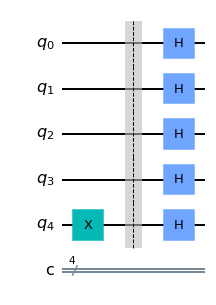

In [7]:
grover_ckt.draw()


Let's run this circuit now. We will obtain the statevector and keep the first n qubits (leaving the |-> state ancilla qubit as is).

In [8]:
svsim = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
qobj = assemble(grover_ckt)                      # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result()                # Do the simulation and return the result
statevector = result.data()['statevector']
statevector = statevector[:2**n]
print("Statevector in input (n) Qubits: ", statevector) 
print("Process Complete!")

Statevector in input (n) Qubits:  [0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j
 0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j
 0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j
 0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j
 0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j
 0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j
 0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j
 0.1767767-2.16489014e-17j 0.1767767-2.16489014e-17j]
Process Complete!


/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Let's plot this state vector on a 2 d plane spanned by the marked element state |a> and the superposition of unmarked states |e>. 

In [9]:
marked = [1,0,1,1] # Corresponds to integer 1101 in binary => 13
ket_a = np.zeros(2**n)
ket_a[13] =1
ket_e = (np.ones(2**n) - ket_a)/np.sqrt(2**n -1)
print("\nKet a: ", ket_a)
print("\nKet e: ", ket_e)

print("Process Complete!")



Ket a:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Ket e:  [0.25819889 0.25819889 0.25819889 0.25819889 0.25819889 0.25819889
 0.25819889 0.25819889 0.25819889 0.25819889 0.25819889 0.25819889
 0.25819889 0.         0.25819889 0.25819889]
Process Complete!


In [10]:
def get_projection(psi,e,a ):
    proj =  [np.real(np.vdot(e,psi)), np.real(np.vdot(a,psi))]
    return proj

def plt_vector(proj, axes =[0.0,1.0,0.0,1.0]):
    x_pos = 0
    y_pos = 0
    x_direct = proj[0]
    y_direct = proj[1]

    # Creating plot
    fig, ax = plt.subplots()
    ax.quiver(x_pos, y_pos, x_direct, y_direct,scale=1.0)

    ax.axis(axes)

    plt.xlabel("|e>")
    plt.ylabel("|a>")
    # show plot
    plt.show()
    
print("Process Complete!")

Process Complete!


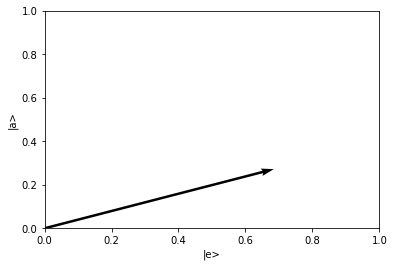

In [11]:
proj = get_projection(statevector, ket_e, ket_a)
plt_vector(proj)
# The vector is closer to |e> than |a>

Now lets add the phase oracle which reflects the state about |e>.

In [12]:
#grover_ckt.append(oracle, list(range(n+1)))
apply_oracle(4,marked,grover_ckt)
grover_ckt.barrier()
print("Process Complete!")

Process Complete!


This is how the circuit looks now.

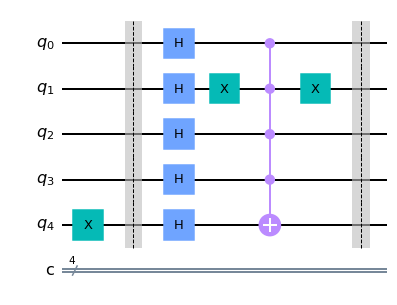

In [13]:
grover_ckt.draw()

Now we reflect about the unform state. We use the function you completed as part of the exercise. 

In [14]:
reflect_uniform(grover_ckt,n)
print("Process Complete!")

Process Complete!


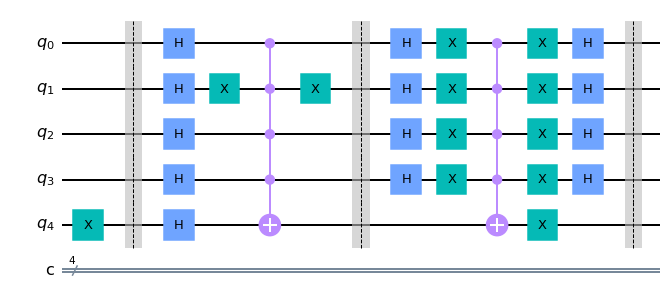

In [15]:
grover_ckt.barrier()
grover_ckt.draw()

Now we run the circuit again and replot the state vector. Observe that it indeed gets rotate colckwise towards the marked state |a>

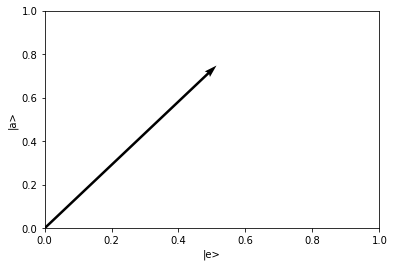

In [16]:
svsim = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
qobj = assemble(grover_ckt)     # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result() # Do the simulation and return the result
statevector = result.data()['statevector']

statevector = statevector[:2**n]
proj = get_projection(statevector, ket_e, ket_a)
plt_vector(proj)

# The vector has now moved closer to |a>

Lets do another step of phase oracle followed by reflection about uniform.

In [17]:
apply_oracle(4,marked,grover_ckt)

grover_ckt.barrier()
reflect_uniform(grover_ckt,n)
grover_ckt.barrier()
print("Process Complete!")

Process Complete!


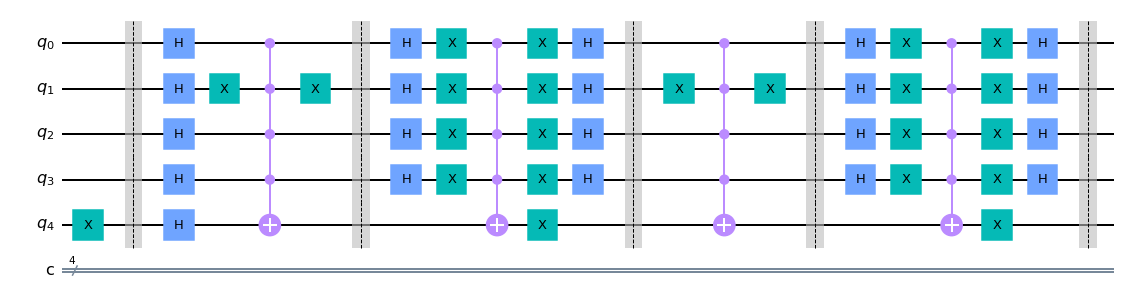

In [18]:
grover_ckt.draw()

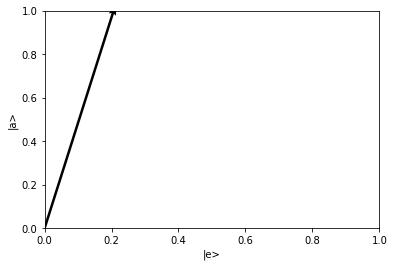

In [19]:
svsim = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
qobj = assemble(grover_ckt)     # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result() # Do the simulation and return the result
statevector = result.data()['statevector']

statevector = statevector[:2**n]
proj = get_projection(statevector, ket_e, ket_a)
plt_vector(proj)

We observe that it indeed rotates clockwise towards |a>. Lets see when we repeat the 2 steps again.

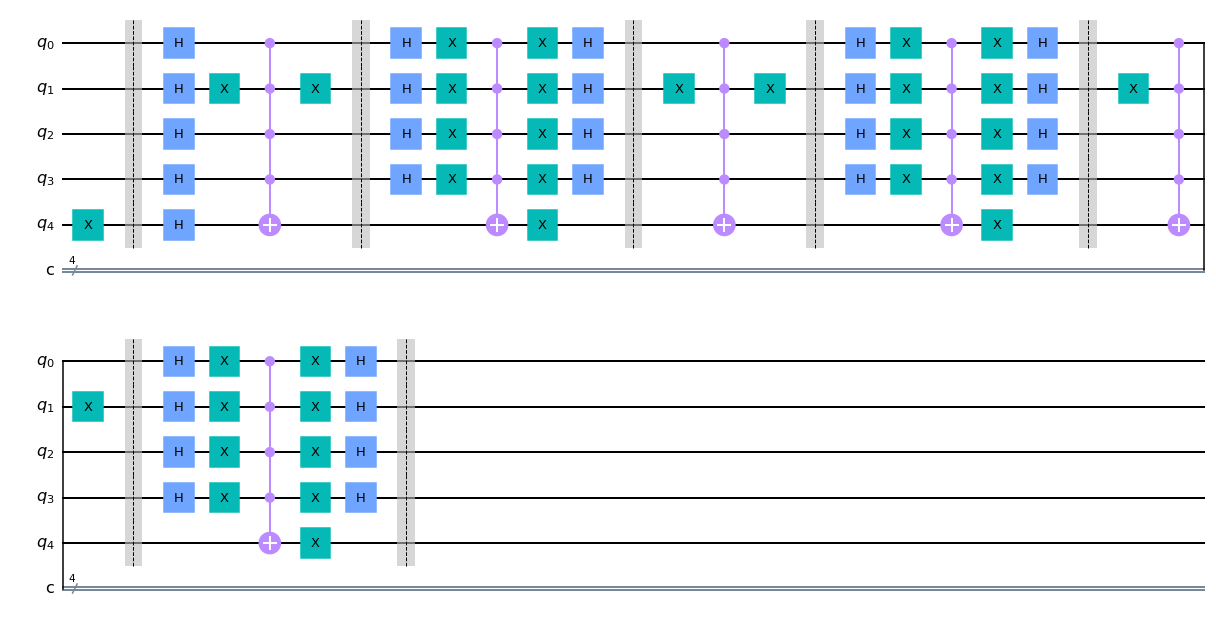

In [20]:
apply_oracle(4,marked,grover_ckt)

grover_ckt.barrier()
reflect_uniform(grover_ckt,n)
grover_ckt.barrier()
grover_ckt.draw()


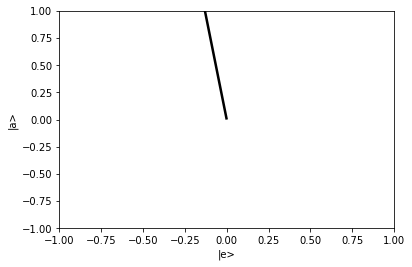

In [21]:
svsim = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
qobj = assemble(grover_ckt)     # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result() # Do the simulation and return the result
statevector = result.data()['statevector']

statevector = statevector[:2**n]
proj = get_projection(statevector, ket_e, ket_a)
plt_vector(proj, axes = [-1.0,1.0,-1.0,1.0])

Now we observe that statevector falls into the second quadrant. At this point further rotations will not help much.

# Exercise 2.1 
Now we compute the theoretical number of rotations which maximize the angle keeping statevector in quadrant I. First compute the initial angle  $\theta_0$. Store it in variable theta0.

In real QCs, we can't 'view' the statevector as measuring it will collapse its superposition.

In [22]:
# theta0 will be sin(1/root(N)) where N = 2**n, where n is the number of input qubits

import math
print("Number of input qubits:", n)
theta0 = math.asin(1/((n**2)**0.5))

print( theta0 )
print("Process Complete!")

Number of input qubits: 4
0.25268025514207865
Process Complete!


# Exercise 2.2
Each rotation increases this by $2 \theta_0$. After T rotations it is $(2T+1)\theta_0$. You need to find the largest such integer T so that it remains in quadrant I. Store it in variable T .

In [23]:
# Find theta_0 such that theta_0 + T * (2 * theta_0) < pi/2, and
# theta_0 + (T+1) * (2 * theta_0) > pi/2
from math import pi        

T = 0
argument = theta0

while True:
    if argument + 2 * theta0 > pi/2:
        break
    argument += 2 * theta0
    T += 1

print("T: ", T) 
print("Process Complete!")

T:  2
Process Complete!


Now to complete the story we create a new circuit and rotate preciely by number of times given bt T. 

In [24]:
n = 4
grover_ckt = QuantumCircuit(n+1, n)
marked = [1,0,1,1] # 1101 element is marked (lsb to msb)=>13
grover_ckt.x(n)
grover_ckt.barrier()
grover_ckt.h(list(range(n+1)))
grover_ckt.barrier()

for _ in range(int(np.floor(T))):
    apply_oracle(4,marked,grover_ckt)

    grover_ckt.barrier()
    reflect_uniform(grover_ckt,n)
    grover_ckt.barrier()

for j in range(n):
    grover_ckt.measure(j,j)

print("Process Complete!")

Process Complete!


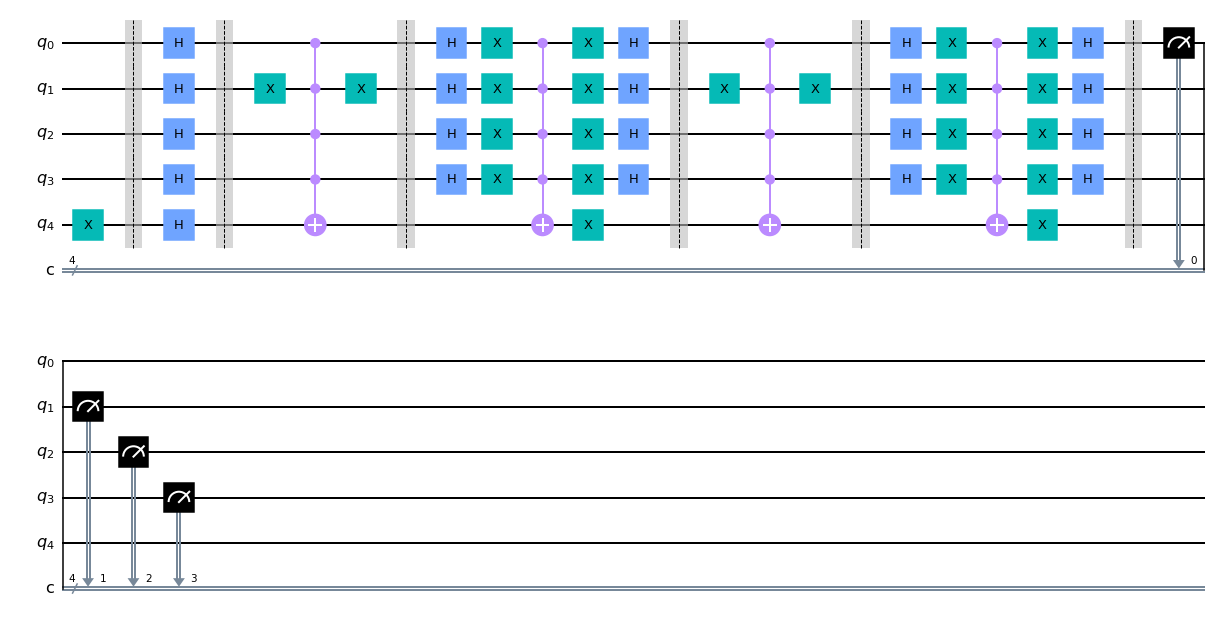

In [25]:
grover_ckt.draw()

In [26]:
sim = Aer.get_backend('qasm_simulator') # Tell Qiskit how to simulate our circuit
qobj = assemble(grover_ckt)             # Create a Qobj from the circuit for the simulator to run
result = sim.run(qobj).result()         # Do the simulation and return the result
print("Process Complete!")

Process Complete!


In [27]:
result

Result(backend_name='qasm_simulator', backend_version='0.9.1', qobj_id='c5e7e472-6340-41f8-8eb3-2f32116044e5', job_id='6ee561f0-d7bc-4e09-9e19-a1fafeb8fee9', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0xf': 1, '0xa': 8, '0xe': 4, '0x1': 8, '0xc': 3, '0x5': 2, '0x8': 6, '0x4': 8, '0x6': 9, '0xd': 933, '0x2': 11, '0xb': 8, '0x9': 3, '0x0': 7, '0x7': 8, '0x3': 5}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3]], creg_sizes=[['c', 4]], global_phase=0.0, memory_slots=4, metadata=None, n_qubits=5, name='circuit-4', qreg_sizes=[['q', 5]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]]), status=DONE, seed_simulator=2476602623, metadata={'parallel_state_update': 8, 'noise': 'ideal', 'measure_sampling': True, 'device': 'CPU', 'num_qubits': 5, 'parallel_shots': 1, 'remapped_qubits': False, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4], 'num_clbits': 4, 'inp

In [28]:
counts = result.get_counts(grover_ckt)
print(counts)

{'1111': 1, '1010': 8, '1110': 4, '0001': 8, '1100': 3, '0101': 2, '1000': 6, '0100': 8, '0110': 9, '1101': 933, '0010': 11, '1011': 8, '1001': 3, '0000': 7, '0111': 8, '0011': 5}


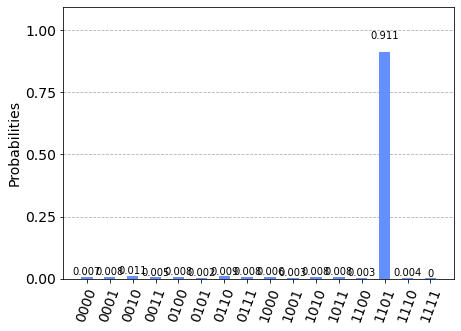

In [29]:
plot_histogram(counts)
# Representation - 1011, so q0 is the LSB and q3 is the MSB

# Concluding remarks and points to ponder
We see that the above plot has highest measured probability for marked index i.e. 13 ( or 1101).
This completes the implementation of Grover's search for a single marked element. Here are a few more points to ponder about for future :-
1. What happens when there are more than 1 marked elements. How will the algorithm change. What is the initial angle and rotation in each step.
2. What if you dont know the number of marked elements. What will be the modfications needed ?

# References 
1. L. K. Grover (1996), "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996), doi:10.1145/237814.237866, arXiv:quant-ph/9605043

1. I. Chuang & M. Nielsen, "Quantum Computation and Quantum Information", Cambridge: Cambridge University Press, 2000.

1. Qiskit Textbook : https://qiskit.org/textbook/ch-algorithms/grover.html
